Simulated path: [5, np.int64(6), np.int64(7), np.int64(6), np.int64(5), np.int64(6), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(3), np.int64(2), np.int64(3), np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0)]
Ruin probability from $5: 0.11636363636363645
Steady state:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


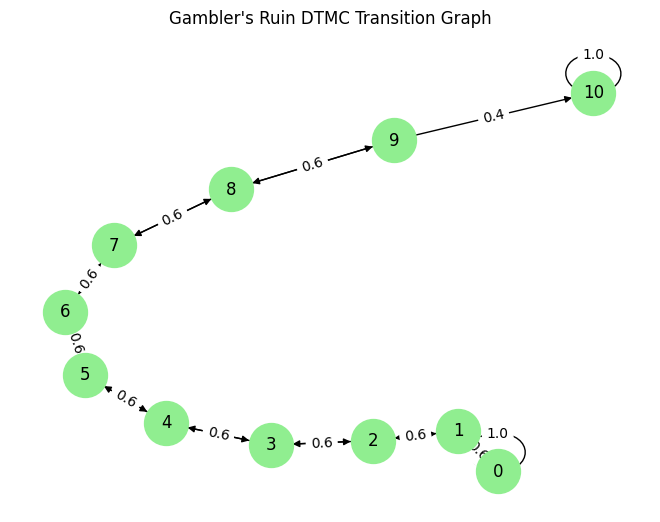

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class GamblerRuinDTMC:
    def __init__(self, N, p):
        self.N = N
        self.p = p
        self.q = 1 - p
        self.states = list(range(N + 1))
        self.P = self._build_transition_matrix()

    def _build_transition_matrix(self):
        P = np.zeros((self.N + 1, self.N + 1))
        for i in range(1, self.N):
            P[i][i + 1] = self.p
            P[i][i - 1] = self.q
        P[0][0] = 1.0  # absorbing at 0
        P[self.N][self.N] = 1.0  # absorbing at N
        return P

    def simulate(self, start, steps):
        state = start
        path = [state]
        for _ in range(steps):
            if state == 0 or state == self.N:
                break
            state = np.random.choice(self.states, p=self.P[state])
            path.append(state)
        return path

    def plot_chain(self):
        G = nx.DiGraph()
        for i in range(self.N + 1):
            for j in range(self.N + 1):
                if self.P[i][j] > 0:
                    G.add_edge(i, j, weight=round(self.P[i][j], 2))

        pos = nx.spring_layout(G)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightgreen')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title("Gambler's Ruin DTMC Transition Graph")
        plt.show()

    def steady_state(self):
        eigvals, eigvecs = np.linalg.eig(self.P.T)
        stat_dist = np.array(eigvecs[:, np.isclose(eigvals, 1)])
        stat_dist = stat_dist[:,0]
        stat_dist = stat_dist / stat_dist.sum()
        return stat_dist.real

    def ruin_probability(self, start):
        # Exact probability that gambler reaches 0 before N
        if self.p == self.q:
            return (self.N - start) / self.N
        else:
            r = self.q / self.p
            return (1 - r**start) / (1 - r**self.N)

# -------------------------------
# Example usage:
model = GamblerRuinDTMC(N=10, p=0.4)
path = model.simulate(start=5, steps=100)
print("Simulated path:", path)
print("Ruin probability from $5:", model.ruin_probability(start=5))
print("Steady state: ",model.steady_state())
model.plot_chain()

In [5]:
import numpy as np

class DTMC:
    def __init__(self, transition_matrix, state_labels=None):
        self.P = np.array(transition_matrix)
        self.n = self.P.shape[0]
        self.states = state_labels if state_labels else list(range(self.n))

    def next_state(self, current_state):
        return np.random.choice(self.n, p=self.P[current_state])

    def simulate(self, start_state, steps):
        trajectory = [start_state]
        current = start_state
        for _ in range(steps):
            current = self.next_state(current)
            trajectory.append(current)
        return [self.states[i] for i in trajectory]

    def steady_state(self, tol=1e-8, max_iter=1000):
        dist = np.ones(self.n) / self.n  # Uniform initial distribution
        for _ in range(max_iter):
            new_dist = dist @ self.P
            if np.linalg.norm(new_dist - dist) < tol:
                break
            dist = new_dist
        return dict(zip(self.states, dist))

# --- Parameters ---
p = 0.3  # Probability of stock falling
q = 0.4  # Probability of stock rising
r = 0.3  # Probability of stock remaining the same

# --- Transition Matrix ---
# States: Fall, Same, Rise
transition_matrix = [
    [p, r, q],
    [p, r, q],
    [p, r, q]
]

state_labels = ["Fall", "Same", "Rise"]

# --- Initialize DTMC ---
mc = DTMC(transition_matrix, state_labels)

# --- Simulate for 10 Days starting from "Same" ---
start_state = state_labels.index("Same")
trajectory = mc.simulate(start_state=start_state, steps=10)

print("10-Day Simulated Stock Movement:")
for day, state in enumerate(trajectory):
    print(f"Day {day}: {state}")

# --- Compute Steady-State Distribution ---
steady = mc.steady_state()
print("\nSteady-State Distribution:")
for state, prob in steady.items():
    print(f"{state}: {prob:.4f}")


10-Day Simulated Stock Movement:
Day 0: Same
Day 1: Rise
Day 2: Rise
Day 3: Fall
Day 4: Rise
Day 5: Rise
Day 6: Rise
Day 7: Rise
Day 8: Rise
Day 9: Same
Day 10: Same

Steady-State Distribution:
Fall: 0.3000
Same: 0.3000
Rise: 0.4000


In [11]:
import numpy as np

def expected_ruin_hitting_time(p, q, r, start=1, target=10):
    N = target
    h = np.zeros(N + 1)  # h[0] = h[N] = 0 (absorbing)

    A = np.zeros((N - 1, N - 1))  # Coefficient matrix
    b = np.ones(N - 1)            # RHS vector

    for i in range(1, N):
        idx = i - 1
        if i == 1:
            # No i-1 if i=1: use h[0] = 0
            A[idx][idx] = 1 - r
            A[idx][idx + 1] = -q
            b[idx] = 1 + p * 0
        elif i == N - 1:
            # No i+1 if i=N-1: use h[N] = 0
            A[idx][idx - 1] = -p
            A[idx][idx] = 1 - r
            b[idx] = 1 + q * 0
        else:
            A[idx][idx - 1] = -p
            A[idx][idx] = 1 - r
            A[idx][idx + 1] = -q

    # Solve A * h = b
    h_sol = np.linalg.solve(A, b)

    # Return expected hitting time from start
    return h_sol[start - 1], h_sol

# Parameters
p = 0.4
q = 0.4
r = 0.2

expected_time, all_times = expected_ruin_hitting_time(p, q, r, start=1, target=10)

print(f"Expected hitting time to reach $0 or $10 starting from $1: {expected_time:.4f}\n")

print("Expected hitting times for each price level:")
for i, ht in enumerate(all_times, start=1):
    print(f"${i} → ($0 or $10): {ht:.4f}")


Expected hitting time to reach $0 or $10 starting from $1: 11.2500

Expected hitting times for each price level:
$1 → ($0 or $10): 11.2500
$2 → ($0 or $10): 20.0000
$3 → ($0 or $10): 26.2500
$4 → ($0 or $10): 30.0000
$5 → ($0 or $10): 31.2500
$6 → ($0 or $10): 30.0000
$7 → ($0 or $10): 26.2500
$8 → ($0 or $10): 20.0000
$9 → ($0 or $10): 11.2500
